In [1]:
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from Bio import Align

from datasets import *
from utils import *
from models import *

# sabdab mlm

In [2]:
from pre_train import load_data
data = load_data("../../Transformer4Ab/data/data_list.pkl")
len(data)

5380

In [3]:
li = [('a', 'b', 0), ('a', 'b', 0), ('a', 'b', 0), ('a', 'b', 1), ('c', 'd', 1)]

list(filter(lambda x:x[-1]==1, li))

[('a', 'b', 1), ('c', 'd', 1)]

In [4]:
oas = pickle.load(open("./OAS/oas_data.pkl", "rb"))
len(oas)

1572406

In [5]:
oas[0]

'GGSISSTSHY/CYFTGTT/ARSAEYVWSRGYFDY/SSNIGAGYG/GDT/QSYDSSLSGSRV'

In [6]:
lines = get_pair(data=data, 
                  epi_seq_length=72, 
                  seq_clip_mode=1, 
                  neg_sample_mode=0, 
                  num_neg=1, 
                  K=48, 
                  use_cache=False, 
                  use_pair=False, 
                  only_epitope=True)
len(lines)

get k nearest AAs as epitope...


  1%|▎                                        | 33/5380 [00:02<05:01, 17.76it/s]

H1 not found in data 31th


  1%|▎                                        | 45/5380 [00:03<06:16, 14.19it/s]

L1 not found in data 45th


  1%|▍                                        | 60/5380 [00:03<04:49, 18.39it/s]

H2 not found in data 59th


  1%|▍                                        | 65/5380 [00:04<04:26, 19.93it/s]

L3 not found in data 65th


  2%|▊                                       | 112/5380 [00:07<04:22, 20.10it/s]

H1 not found in data 114th


  3%|█                                       | 138/5380 [00:09<04:57, 17.63it/s]

H1 not found in data 134th


  3%|█▎                                      | 182/5380 [00:11<04:54, 17.67it/s]

H3 not found in data 182th
L1 not found in data 182th


  4%|█▍                                      | 193/5380 [00:12<06:17, 13.75it/s]

H3 not found in data 194th


  4%|█▍                                      | 200/5380 [00:13<07:57, 10.85it/s]

H3 not found in data 198th


  4%|█▌                                      | 213/5380 [00:14<05:39, 15.24it/s]

L1 not found in data 215th


  4%|█▋                                      | 229/5380 [00:16<06:57, 12.33it/s]

H3 not found in data 230th


  4%|█▊                                      | 237/5380 [00:17<08:06, 10.56it/s]

L1 not found in data 237th


  5%|██▏                                     | 287/5380 [00:21<07:47, 10.90it/s]

H3 not found in data 287th


  6%|██▎                                     | 306/5380 [00:22<05:04, 16.69it/s]

H1 not found in data 308th


  6%|██▍                                     | 333/5380 [00:24<06:25, 13.09it/s]

H3 not found in data 331th


  7%|██▋                                     | 356/5380 [00:25<05:54, 14.19it/s]

H3 not found in data 358th
L3 not found in data 358th


  7%|██▋                                     | 368/5380 [00:26<06:12, 13.46it/s]

L1 not found in data 368th


  8%|███▎                                    | 442/5380 [00:31<04:26, 18.56it/s]

H1 not found in data 442th


  8%|███▎                                    | 447/5380 [00:32<07:03, 11.64it/s]

H3 not found in data 447th


  9%|███▌                                    | 486/5380 [00:35<05:22, 15.20it/s]

H3 not found in data 488th


  9%|███▋                                    | 495/5380 [00:37<10:36,  7.67it/s]

L2 not found in data 495th


  9%|███▊                                    | 508/5380 [00:38<06:54, 11.75it/s]

L1 not found in data 510th


 10%|███▉                                    | 525/5380 [00:39<03:55, 20.61it/s]

H1 not found in data 522th
L1 not found in data 525th


 10%|███▉                                    | 532/5380 [00:40<04:42, 17.16it/s]

H3 not found in data 529th


 11%|████▏                                   | 569/5380 [00:42<04:22, 18.34it/s]

L1 not found in data 570th


 11%|████▍                                   | 600/5380 [00:44<05:35, 14.25it/s]

H1 not found in data 601th


 11%|████▌                                   | 607/5380 [00:45<05:32, 14.37it/s]

L1 not found in data 608th


 11%|████▌                                   | 613/5380 [00:45<07:19, 10.86it/s]

L2 not found in data 615th


 12%|████▋                                   | 634/5380 [00:47<03:42, 21.29it/s]

H1 not found in data 629th


 13%|█████                                   | 679/5380 [00:49<05:30, 14.21it/s]

L1 not found in data 680th


 14%|█████▌                                  | 751/5380 [00:55<04:57, 15.56it/s]

H1 not found in data 752th


 15%|█████▊                                  | 781/5380 [00:56<03:18, 23.16it/s]

H3 not found in data 779th


 15%|█████▊                                  | 787/5380 [00:57<03:46, 20.29it/s]

H3 not found in data 787th
L1 not found in data 787th


 15%|█████▊                                  | 790/5380 [00:57<06:40, 11.45it/s]

H3 not found in data 792th
L3 not found in data 792th


 16%|██████▍                                 | 867/5380 [01:02<03:31, 21.33it/s]

H2 not found in data 869th


 16%|██████▍                                 | 873/5380 [01:03<05:15, 14.30it/s]

L1 not found in data 875th


 17%|██████▋                                 | 897/5380 [01:04<04:01, 18.54it/s]

L1 not found in data 897th


 17%|██████▊                                 | 910/5380 [01:06<05:28, 13.59it/s]

L1 not found in data 910th


 17%|██████▊                                 | 919/5380 [01:07<05:44, 12.96it/s]

L1 not found in data 919th


 18%|███████▏                                | 963/5380 [01:10<03:55, 18.75it/s]

H3 not found in data 964th


 18%|███████▎                                | 976/5380 [01:11<04:22, 16.76it/s]

H3 not found in data 974th


 18%|███████▎                                | 987/5380 [01:12<05:06, 14.35it/s]

H2 not found in data 985th


 19%|███████▎                               | 1011/5380 [01:13<04:07, 17.64it/s]

H1 not found in data 1010th
L1 not found in data 1011th


 19%|███████▍                               | 1020/5380 [01:14<04:42, 15.43it/s]

H3 not found in data 1021th


 19%|███████▍                               | 1022/5380 [01:14<10:15,  7.08it/s]

H1 not found in data 1022th


 20%|███████▉                               | 1100/5380 [01:20<03:06, 22.89it/s]

L1 not found in data 1101th


 21%|████████                               | 1107/5380 [01:21<06:41, 10.65it/s]

H3 not found in data 1103th


 22%|████████▌                              | 1183/5380 [01:26<03:36, 19.36it/s]

H2 not found in data 1180th


 22%|████████▋                              | 1191/5380 [01:27<06:39, 10.48it/s]

L1 not found in data 1191th


 23%|████████▊                              | 1220/5380 [01:29<04:18, 16.12it/s]

H3 not found in data 1217th


 23%|████████▉                              | 1233/5380 [01:30<05:02, 13.69it/s]

H3 not found in data 1233th


 24%|█████████▍                             | 1295/5380 [01:34<03:27, 19.66it/s]

H1 not found in data 1296th


 24%|█████████▍                             | 1298/5380 [01:34<04:15, 15.97it/s]

L2 not found in data 1299th


 24%|█████████▍                             | 1304/5380 [01:35<06:03, 11.23it/s]

L1 not found in data 1306th


 25%|█████████▋                             | 1332/5380 [01:37<03:54, 17.23it/s]

H1 not found in data 1334th
L1 not found in data 1334th


 25%|█████████▊                             | 1350/5380 [01:38<04:30, 14.90it/s]

H1 not found in data 1349th


 26%|█████████▉                             | 1374/5380 [01:39<05:05, 13.10it/s]

H3 not found in data 1373th


 26%|██████████                             | 1383/5380 [01:40<03:38, 18.27it/s]

H1 not found in data 1383th


 26%|██████████▎                            | 1425/5380 [01:43<03:26, 19.16it/s]

H1 not found in data 1423th


 27%|██████████▎                            | 1431/5380 [01:43<03:27, 19.03it/s]

H1 not found in data 1434th


 27%|██████████▌                            | 1452/5380 [01:44<02:51, 22.92it/s]

H1 not found in data 1452th


 28%|██████████▊                            | 1496/5380 [01:47<02:54, 22.21it/s]

L1 not found in data 1496th


 29%|███████████▏                           | 1546/5380 [01:51<05:06, 12.53it/s]

L1 not found in data 1548th


 29%|███████████▏                           | 1549/5380 [01:51<05:49, 10.95it/s]

L1 not found in data 1549th


 29%|███████████▎                           | 1553/5380 [01:52<06:44,  9.46it/s]

H3 not found in data 1554th


 29%|███████████▎                           | 1560/5380 [01:52<06:24,  9.94it/s]

H3 not found in data 1560th


 29%|███████████▎                           | 1564/5380 [01:53<08:23,  7.59it/s]

H1 not found in data 1564th


 29%|███████████▍                           | 1584/5380 [01:55<04:17, 14.75it/s]

H3 not found in data 1582th
H1 not found in data 1584th


 30%|███████████▌                           | 1591/5380 [01:56<05:48, 10.86it/s]

L1 not found in data 1592th


 30%|███████████▌                           | 1602/5380 [01:57<05:11, 12.13it/s]

L1 not found in data 1601th


 30%|███████████▋                           | 1613/5380 [01:57<04:12, 14.93it/s]

H3 not found in data 1613th


 30%|███████████▊                           | 1632/5380 [01:59<03:25, 18.26it/s]

H3 not found in data 1634th


 31%|███████████▉                           | 1646/5380 [02:00<03:49, 16.24it/s]

L1 not found in data 1647th


 31%|████████████                           | 1664/5380 [02:01<03:12, 19.32it/s]

H3 not found in data 1664th


 32%|████████████▎                          | 1698/5380 [02:04<04:03, 15.14it/s]

L1 not found in data 1699th
L1 not found in data 1700th


 32%|████████████▍                          | 1715/5380 [02:06<05:06, 11.95it/s]

H3 not found in data 1716th
L1 not found in data 1716th


 33%|████████████▊                          | 1771/5380 [02:09<02:43, 22.12it/s]

L1 not found in data 1767th


 33%|████████████▉                          | 1784/5380 [02:10<04:56, 12.11it/s]

H3 not found in data 1785th


 33%|█████████████                          | 1797/5380 [02:11<03:48, 15.66it/s]

H3 not found in data 1793th


 34%|█████████████▎                         | 1835/5380 [02:13<03:20, 17.68it/s]

H1 not found in data 1835th


 34%|█████████████▎                         | 1839/5380 [02:14<05:14, 11.27it/s]

H1 not found in data 1836th


 35%|█████████████▍                         | 1858/5380 [02:15<04:23, 13.39it/s]

H3 not found in data 1861th


 35%|█████████████▌                         | 1870/5380 [02:17<04:38, 12.59it/s]

H3 not found in data 1870th


 35%|█████████████▋                         | 1880/5380 [02:17<03:24, 17.14it/s]

H1 not found in data 1877th


 35%|█████████████▊                         | 1907/5380 [02:19<03:32, 16.38it/s]

L2 not found in data 1907th


 36%|█████████████▉                         | 1917/5380 [02:20<04:57, 11.64it/s]

L2 not found in data 1915th


 36%|██████████████▏                        | 1962/5380 [02:23<03:17, 17.28it/s]

L1 not found in data 1962th


 37%|██████████████▎                        | 1966/5380 [02:23<04:09, 13.71it/s]

H1 not found in data 1964th


 37%|██████████████▎                        | 1972/5380 [02:24<04:10, 13.59it/s]

H2 not found in data 1971th


 37%|██████████████▎                        | 1983/5380 [02:24<02:34, 22.01it/s]

H3 not found in data 1987th


 37%|██████████████▌                        | 2003/5380 [02:26<03:43, 15.10it/s]

L3 not found in data 2002th


 39%|███████████████▎                       | 2117/5380 [02:32<03:37, 15.02it/s]

L1 not found in data 2118th


 40%|███████████████▍                       | 2129/5380 [02:34<04:22, 12.39it/s]

L1 not found in data 2129th


 40%|███████████████▌                       | 2140/5380 [02:35<03:55, 13.77it/s]

H3 not found in data 2138th


 41%|███████████████▉                       | 2198/5380 [02:38<02:28, 21.45it/s]

H3 not found in data 2193th


 42%|████████████████▏                      | 2241/5380 [02:41<03:46, 13.88it/s]

H1 not found in data 2242th


 42%|████████████████▍                      | 2267/5380 [02:42<02:34, 20.15it/s]

L1 not found in data 2268th


 42%|████████████████▍                      | 2270/5380 [02:43<04:22, 11.85it/s]

H3 not found in data 2271th


 43%|████████████████▋                      | 2296/5380 [02:45<02:16, 22.65it/s]

H3 not found in data 2293th


 43%|████████████████▊                      | 2326/5380 [02:46<02:51, 17.80it/s]

L1 not found in data 2327th


 45%|█████████████████▌                     | 2417/5380 [02:53<02:31, 19.49it/s]

H1 not found in data 2413th


 46%|█████████████████▊                     | 2460/5380 [02:55<02:10, 22.30it/s]

H1 not found in data 2462th


 46%|█████████████████▉                     | 2477/5380 [02:57<03:32, 13.69it/s]

H3 not found in data 2477th


 47%|██████████████████▏                    | 2514/5380 [02:59<03:03, 15.58it/s]

H1 not found in data 2513th


 47%|██████████████████▍                    | 2540/5380 [03:02<04:37, 10.25it/s]

H3 not found in data 2540th


 48%|██████████████████▋                    | 2575/5380 [03:05<02:24, 19.38it/s]

H3 not found in data 2573th


 48%|██████████████████▊                    | 2596/5380 [03:06<03:07, 14.87it/s]

H1 not found in data 2598th


 48%|██████████████████▉                    | 2605/5380 [03:07<03:49, 12.09it/s]

H1 not found in data 2603th


 49%|███████████████████▏                   | 2643/5380 [03:09<02:35, 17.59it/s]

H3 not found in data 2639th


 49%|███████████████████▏                   | 2645/5380 [03:10<03:28, 13.09it/s]

L1 not found in data 2645th


 49%|███████████████████▎                   | 2661/5380 [03:11<03:14, 14.00it/s]

H1 not found in data 2661th


 50%|███████████████████▎                   | 2670/5380 [03:11<02:53, 15.66it/s]

H3 not found in data 2665th


 50%|███████████████████▌                   | 2696/5380 [03:13<02:46, 16.12it/s]

H1 not found in data 2696th


 51%|███████████████████▋                   | 2724/5380 [03:16<03:23, 13.02it/s]

L3 not found in data 2723th


 51%|███████████████████▊                   | 2740/5380 [03:17<02:35, 17.03it/s]

L1 not found in data 2740th


 51%|███████████████████▉                   | 2744/5380 [03:18<06:36,  6.65it/s]

H3 not found in data 2744th


 51%|███████████████████▉                   | 2746/5380 [03:19<06:59,  6.27it/s]

L1 not found in data 2748th
L1 not found in data 2751th


 51%|████████████████████                   | 2770/5380 [03:20<02:26, 17.79it/s]

L1 not found in data 2764th
H3 not found in data 2771th


 53%|████████████████████▌                  | 2838/5380 [03:25<02:51, 14.82it/s]

H1 not found in data 2838th


 53%|████████████████████▊                  | 2863/5380 [03:27<02:32, 16.50it/s]

H3 not found in data 2864th


 54%|████████████████████▉                  | 2891/5380 [03:29<03:27, 11.97it/s]

L3 not found in data 2892th


 54%|█████████████████████▏                 | 2923/5380 [03:32<01:29, 27.60it/s]

L1 not found in data 2920th


 55%|█████████████████████▍                 | 2960/5380 [03:34<01:45, 22.90it/s]

H1 not found in data 2955th


 55%|█████████████████████▌                 | 2966/5380 [03:34<01:29, 27.12it/s]

H3 not found in data 2969th


 56%|█████████████████████▋                 | 2989/5380 [03:36<01:54, 20.96it/s]

H3 not found in data 2983th


 56%|█████████████████████▋                 | 2997/5380 [03:36<02:00, 19.71it/s]

H3 not found in data 2995th


 56%|█████████████████████▊                 | 3003/5380 [03:37<02:22, 16.64it/s]

H3 not found in data 3005th


 56%|█████████████████████▊                 | 3006/5380 [03:38<05:35,  7.07it/s]

L3 not found in data 3007th


 56%|█████████████████████▉                 | 3028/5380 [03:39<02:47, 14.03it/s]

H3 not found in data 3028th


 57%|██████████████████████▎                | 3081/5380 [03:43<01:53, 20.28it/s]

L1 not found in data 3083th


 57%|██████████████████████▍                | 3091/5380 [03:45<02:44, 13.91it/s]

H1 not found in data 3089th


 58%|██████████████████████▍                | 3094/5380 [03:45<02:52, 13.23it/s]

L2 not found in data 3094th


 58%|██████████████████████▍                | 3100/5380 [03:46<04:07,  9.21it/s]

H3 not found in data 3101th


 58%|██████████████████████▊                | 3142/5380 [03:48<02:09, 17.30it/s]

H3 not found in data 3142th


 58%|██████████████████████▊                | 3144/5380 [03:49<06:45,  5.52it/s]

L2 not found in data 3147th


 59%|██████████████████████▉                | 3164/5380 [03:51<02:41, 13.73it/s]

L1 not found in data 3164th


 59%|███████████████████████                | 3181/5380 [03:52<02:14, 16.33it/s]

H2 not found in data 3180th


 60%|███████████████████████▎               | 3219/5380 [03:54<02:09, 16.65it/s]

H1 not found in data 3217th


 60%|███████████████████████▍               | 3227/5380 [03:55<02:02, 17.64it/s]

H3 not found in data 3224th


 60%|███████████████████████▍               | 3233/5380 [03:55<02:14, 15.93it/s]

L1 not found in data 3233th


 61%|███████████████████████▋               | 3273/5380 [03:58<02:14, 15.67it/s]

H1 not found in data 3274th


 61%|███████████████████████▊               | 3277/5380 [03:59<04:01,  8.72it/s]

H3 not found in data 3279th
L1 not found in data 3281th


 61%|███████████████████████▊               | 3287/5380 [04:00<03:10, 11.00it/s]

H1 not found in data 3286th


 61%|███████████████████████▉               | 3296/5380 [04:00<02:07, 16.36it/s]

L1 not found in data 3295th


 61%|███████████████████████▉               | 3300/5380 [04:00<02:19, 14.93it/s]

L1 not found in data 3303th


 62%|████████████████████████▏              | 3331/5380 [04:02<01:49, 18.74it/s]

L1 not found in data 3328th
L3 not found in data 3331th


 62%|████████████████████████▏              | 3335/5380 [04:03<03:53,  8.74it/s]

H3 not found in data 3336th


 63%|████████████████████████▍              | 3379/5380 [04:07<02:16, 14.67it/s]

H3 not found in data 3380th


 63%|████████████████████████▌              | 3394/5380 [04:08<02:30, 13.17it/s]

H1 not found in data 3394th


 63%|████████████████████████▋              | 3413/5380 [04:10<02:32, 12.92it/s]

L1 not found in data 3411th


 64%|████████████████████████▊              | 3422/5380 [04:11<02:35, 12.56it/s]

H3 not found in data 3425th


 65%|█████████████████████████▏             | 3473/5380 [04:14<01:43, 18.39it/s]

H1 not found in data 3474th


 65%|█████████████████████████▎             | 3488/5380 [04:16<02:44, 11.51it/s]

L1 not found in data 3491th


 65%|█████████████████████████▍             | 3513/5380 [04:18<02:07, 14.70it/s]

L1 not found in data 3513th


 65%|█████████████████████████▍             | 3515/5380 [04:19<03:29,  8.91it/s]

H3 not found in data 3517th


 65%|█████████████████████████▌             | 3518/5380 [04:19<03:24,  9.12it/s]

H3 not found in data 3518th
L1 not found in data 3518th


 66%|█████████████████████████▌             | 3531/5380 [04:20<02:22, 12.94it/s]

L1 not found in data 3533th


 66%|█████████████████████████▋             | 3552/5380 [04:22<02:18, 13.17it/s]

H3 not found in data 3553th


 66%|█████████████████████████▊             | 3563/5380 [04:23<02:22, 12.74it/s]

H1 not found in data 3564th
L2 not found in data 3564th


 66%|█████████████████████████▊             | 3565/5380 [04:23<02:54, 10.42it/s]

H3 not found in data 3565th


 67%|██████████████████████████▎            | 3625/5380 [04:27<01:22, 21.16it/s]

L1 not found in data 3621th
H3 not found in data 3625th


 68%|██████████████████████████▌            | 3660/5380 [04:30<02:15, 12.69it/s]

H1 not found in data 3660th


 68%|██████████████████████████▌            | 3662/5380 [04:30<02:51, 10.00it/s]

H3 not found in data 3662th


 68%|██████████████████████████▋            | 3683/5380 [04:31<01:17, 21.79it/s]

H3 not found in data 3684th


 69%|██████████████████████████▉            | 3713/5380 [04:34<01:52, 14.86it/s]

H3 not found in data 3711th


 69%|██████████████████████████▉            | 3724/5380 [04:35<02:14, 12.30it/s]

H1 not found in data 3723th


 69%|███████████████████████████            | 3728/5380 [04:35<02:24, 11.43it/s]

H3 not found in data 3729th


 70%|███████████████████████████▏           | 3746/5380 [04:36<02:18, 11.81it/s]

H3 not found in data 3750th


 70%|███████████████████████████▎           | 3769/5380 [04:38<01:37, 16.49it/s]

L1 not found in data 3770th


 70%|███████████████████████████▍           | 3791/5380 [04:39<01:31, 17.33it/s]

L1 not found in data 3791th


 71%|███████████████████████████▍           | 3793/5380 [04:40<02:04, 12.72it/s]

H1 not found in data 3794th


 71%|███████████████████████████▋           | 3814/5380 [04:42<02:17, 11.41it/s]

H3 not found in data 3815th


 71%|███████████████████████████▋           | 3819/5380 [04:43<03:21,  7.74it/s]

H1 not found in data 3820th


 72%|███████████████████████████▉           | 3850/5380 [04:45<01:26, 17.66it/s]

L1 not found in data 3853th


 72%|████████████████████████████           | 3876/5380 [04:47<01:05, 22.83it/s]

H1 not found in data 3866th
H3 not found in data 3874th


 72%|████████████████████████████▏          | 3883/5380 [04:47<01:15, 19.85it/s]

L1 not found in data 3885th


 72%|████████████████████████████▏          | 3895/5380 [04:48<01:56, 12.72it/s]

L1 not found in data 3894th
H1 not found in data 3895th


 73%|████████████████████████████▎          | 3906/5380 [04:49<01:20, 18.22it/s]

H3 not found in data 3903th


 73%|████████████████████████████▍          | 3930/5380 [04:50<01:56, 12.46it/s]

H2 not found in data 3931th


 74%|████████████████████████████▊          | 3971/5380 [04:54<01:55, 12.20it/s]

H3 not found in data 3972th


 74%|████████████████████████████▊          | 3982/5380 [04:55<01:37, 14.35it/s]

H3 not found in data 3982th


 74%|████████████████████████████▉          | 3984/5380 [04:55<02:36,  8.91it/s]

L3 not found in data 3983th


 74%|████████████████████████████▉          | 3990/5380 [04:55<01:33, 14.88it/s]

H1 not found in data 3992th


 75%|█████████████████████████████▎         | 4038/5380 [04:59<01:17, 17.36it/s]

L1 not found in data 4038th


 75%|█████████████████████████████▍         | 4056/5380 [05:00<01:47, 12.35it/s]

L1 not found in data 4057th


 76%|█████████████████████████████▍         | 4062/5380 [05:01<01:49, 12.08it/s]

L1 not found in data 4062th


 76%|█████████████████████████████▌         | 4072/5380 [05:02<02:13,  9.82it/s]

L1 not found in data 4073th


 76%|█████████████████████████████▊         | 4113/5380 [05:04<00:44, 28.77it/s]

L1 not found in data 4114th


 77%|██████████████████████████████▏        | 4157/5380 [05:06<00:49, 24.51it/s]

H3 not found in data 4150th


 78%|██████████████████████████████▎        | 4180/5380 [05:08<01:04, 18.59it/s]

H3 not found in data 4177th


 78%|██████████████████████████████▍        | 4193/5380 [05:08<00:54, 21.93it/s]

H3 not found in data 4187th


 79%|██████████████████████████████▊        | 4243/5380 [05:12<01:16, 14.81it/s]

L1 not found in data 4243th


 79%|██████████████████████████████▊        | 4249/5380 [05:12<01:19, 14.18it/s]

L2 not found in data 4249th


 80%|███████████████████████████████▎       | 4320/5380 [05:16<00:48, 21.81it/s]

H1 not found in data 4319th


 81%|███████████████████████████████▌       | 4358/5380 [05:19<00:54, 18.62it/s]

H3 not found in data 4357th


 81%|███████████████████████████████▊       | 4381/5380 [05:20<01:09, 14.39it/s]

H1 not found in data 4381th


 84%|████████████████████████████████▊      | 4525/5380 [05:29<00:45, 18.80it/s]

L1 not found in data 4523th
L1 not found in data 4527th


 85%|█████████████████████████████████      | 4555/5380 [05:32<00:59, 13.83it/s]

L1 not found in data 4555th


 85%|█████████████████████████████████▎     | 4593/5380 [05:34<00:45, 17.27it/s]

H3 not found in data 4593th


 86%|█████████████████████████████████▎     | 4603/5380 [05:35<00:48, 15.92it/s]

H3 not found in data 4602th
H1 not found in data 4603th


 86%|█████████████████████████████████▍     | 4608/5380 [05:35<00:55, 13.84it/s]

H3 not found in data 4607th


 86%|█████████████████████████████████▍     | 4610/5380 [05:35<00:54, 14.19it/s]

L3 not found in data 4611th


 86%|█████████████████████████████████▋     | 4641/5380 [05:38<01:19,  9.32it/s]

H1 not found in data 4640th


 86%|█████████████████████████████████▋     | 4643/5380 [05:38<01:09, 10.60it/s]

H3 not found in data 4643th


 87%|█████████████████████████████████▊     | 4671/5380 [05:41<00:52, 13.49it/s]

H3 not found in data 4671th


 87%|█████████████████████████████████▉     | 4681/5380 [05:43<01:28,  7.93it/s]

H1 not found in data 4681th
L3 not found in data 4681th


 87%|██████████████████████████████████     | 4694/5380 [05:44<00:49, 13.91it/s]

L1 not found in data 4694th


 89%|██████████████████████████████████▋    | 4786/5380 [05:50<00:26, 22.40it/s]

L2 not found in data 4785th


 89%|██████████████████████████████████▊    | 4808/5380 [05:51<00:43, 13.22it/s]

L3 not found in data 4810th


 90%|██████████████████████████████████▉    | 4821/5380 [05:52<00:41, 13.61it/s]

H1 not found in data 4821th


 90%|███████████████████████████████████    | 4836/5380 [05:53<00:39, 13.61it/s]

H3 not found in data 4837th


 90%|███████████████████████████████████▏   | 4852/5380 [05:54<00:25, 20.54it/s]

H3 not found in data 4848th


 91%|███████████████████████████████████▋   | 4915/5380 [05:58<00:20, 22.72it/s]

L3 not found in data 4917th


 91%|███████████████████████████████████▋   | 4920/5380 [05:59<00:49,  9.35it/s]

H3 not found in data 4921th


 92%|███████████████████████████████████▋   | 4925/5380 [06:00<01:11,  6.37it/s]

L3 not found in data 4922th
L2 not found in data 4928th


 92%|███████████████████████████████████▊   | 4936/5380 [06:01<00:46,  9.52it/s]

L1 not found in data 4938th


 93%|████████████████████████████████████▍  | 5030/5380 [06:07<00:12, 28.77it/s]

L1 not found in data 5026th


 94%|████████████████████████████████████▍  | 5035/5380 [06:07<00:12, 27.95it/s]

H1 not found in data 5036th


 94%|████████████████████████████████████▊  | 5083/5380 [06:11<00:19, 15.22it/s]

L1 not found in data 5084th


 96%|█████████████████████████████████████▏ | 5138/5380 [06:15<00:19, 12.18it/s]

L3 not found in data 5139th


 96%|█████████████████████████████████████▎ | 5152/5380 [06:16<00:15, 14.70it/s]

L1 not found in data 5151th


 96%|█████████████████████████████████████▌ | 5174/5380 [06:18<00:13, 15.37it/s]

H3 not found in data 5177th


 97%|█████████████████████████████████████▋ | 5205/5380 [06:20<00:09, 18.06it/s]

L1 not found in data 5205th


 97%|█████████████████████████████████████▋ | 5207/5380 [06:21<00:27,  6.34it/s]

H3 not found in data 5210th


 97%|█████████████████████████████████████▊ | 5216/5380 [06:22<00:15, 10.33it/s]

L1 not found in data 5216th
L1 not found in data 5217th


 97%|█████████████████████████████████████▉ | 5233/5380 [06:24<00:13, 10.97it/s]

H2 not found in data 5235th


 98%|██████████████████████████████████████▏| 5269/5380 [06:27<00:05, 22.19it/s]

H1 not found in data 5270th
H3 not found in data 5273th


 99%|██████████████████████████████████████▌| 5320/5380 [06:29<00:03, 18.08it/s]

H3 not found in data 5317th
H1 not found in data 5322th


 99%|██████████████████████████████████████▋| 5333/5380 [06:31<00:03, 13.19it/s]

H1 not found in data 5332th


 99%|██████████████████████████████████████▊| 5346/5380 [06:31<00:01, 22.51it/s]

H3 not found in data 5340th
H3 not found in data 5347th


100%|███████████████████████████████████████| 5380/5380 [06:33<00:00, 13.66it/s]


Start getting pair data...
seq_clip_mode: 1	neg_sample_mode: 0	use_pair: False	


100%|███████████████████████████████████████| 5380/5380 [01:23<00:00, 64.08it/s]


2194

In [18]:
lines[123]

('GYIFTDYE/IHPGSSGT/TRKDY/QDINSF/RAN/LQYDDFPLT',
 'GATPEDLNQKL**###########################################################',
 1)

In [19]:
lines[123][1].strip("#")

'GATPEDLNQKL**'

# load

In [2]:
ckpt = torch.load("/home/user/wanzhang/Transformer4Ab-locla/results/OAS/0619031446/model_best.pth")
ckpt

PESILM(
  (embedding): Embedding(27, 32)
  (enc): ModuleList(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=32, out_features=64, bias=True)
        (fc_v): Linear(in_features=32, out_features=64, bias=True)
        (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=32, out_features=64, bias=True)
        (fc_k): Linear(in_features=64, out_features=64, bias=True)
        (fc_v): Linear(in_features=64, out_features=64, bias=True)
        (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=64, out_features=64, bias=True)
      )
    )
    (1): ISAB(
      (mab0): MAB(
        (fc_q): Linea

In [3]:

model = SetTransformer(dim_input=32, 
                        num_outputs=128, 
                        dim_output=32, 
                        dim_hidden=64, 
                        num_inds=128, 
                        num_heads=4, 
                        ln=True, 
                        dropout=0.5, 
                        use_coattn=True, 
                        share=False, 
                        use_BSS=False, 
                        use_CLIP=False, 
                        use_CosCLF=False).cuda()
model

SetTransformer(
  (embedding): Embedding(27, 32)
  (para_enc): ModuleList(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=32, out_features=64, bias=True)
        (fc_v): Linear(in_features=32, out_features=64, bias=True)
        (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=32, out_features=64, bias=True)
        (fc_k): Linear(in_features=64, out_features=64, bias=True)
        (fc_v): Linear(in_features=64, out_features=64, bias=True)
        (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=64, out_features=64, bias=True)
      )
    )
    (1): ISAB(
      (mab0): MAB(
        

In [6]:
ckpt.embedding.weight

Parameter containing:
tensor([[ 1.4620e-01, -8.3880e-01, -6.2061e-01,  9.9582e-01,  3.0063e-01,
          8.4904e-01,  1.1921e-01, -9.4688e-01, -1.6801e+00,  1.3882e+00,
         -1.5119e-01,  1.7802e+00,  5.3363e-01, -3.5644e-01,  1.3829e+00,
         -6.1947e-01, -1.7824e+00, -5.2789e-03, -1.1573e+00, -9.5068e-02,
         -1.8752e-01, -2.5022e-02,  7.7781e-01, -1.4454e+00,  6.6900e-01,
         -1.1228e+00,  7.6494e-01,  6.8458e-01,  1.5042e+00,  1.1081e+00,
          4.6770e-01,  1.0787e+00],
        [ 1.9274e+00,  7.6771e-01,  8.0347e-01, -4.6211e-01, -2.7135e-01,
          5.5087e-01, -3.0601e-01,  3.3252e-01,  1.4343e-01, -2.1932e-03,
         -1.2640e-01,  3.4158e-03,  5.7986e-01, -3.5765e+00, -8.8542e-01,
          7.8550e-01, -1.3469e+00, -9.7037e-01,  1.3052e+00, -6.1765e-01,
          3.3841e-01, -1.3041e+00,  8.7251e-01, -2.7458e-02, -3.8687e-01,
         -8.1483e-01, -7.9720e-01, -1.5759e+00, -1.0317e+00,  4.6451e-01,
         -1.3614e+00, -2.2352e-01],
        [ 7.0435e-

In [16]:
model.para_enc.state_dict()

OrderedDict([('0.I',
              tensor([[[-0.0033,  0.0161, -0.0259,  ..., -0.0158,  0.0033, -0.0249],
                       [ 0.0158,  0.0085, -0.0030,  ..., -0.0180, -0.0195,  0.0187],
                       [-0.0243, -0.0026,  0.0134,  ..., -0.0127, -0.0212, -0.0156],
                       ...,
                       [-0.0118, -0.0105, -0.0070,  ...,  0.0154,  0.0102, -0.0045],
                       [-0.0232,  0.0261,  0.0166,  ..., -0.0192, -0.0121, -0.0051],
                       [ 0.0189,  0.0223,  0.0009,  ..., -0.0061,  0.0155, -0.0059]]],
                     device='cuda:0')),
             ('0.mab0.fc_q.weight',
              tensor([[-0.0282,  0.1013,  0.0541,  ...,  0.0932, -0.1200,  0.0664],
                      [ 0.0834,  0.0380, -0.0109,  ..., -0.1187, -0.1204, -0.0407],
                      [ 0.0399,  0.0403, -0.0262,  ..., -0.0598,  0.0691,  0.1159],
                      ...,
                      [-0.0747, -0.1175, -0.1073,  ..., -0.0463, -0.0546, -0.0021],


In [15]:
ckpt.enc.state_dict()

OrderedDict([('0.I',
              tensor([[[-0.0114,  0.0335, -0.0624,  ...,  0.0193, -0.0011,  0.0038],
                       [ 0.0220,  0.0014, -0.0072,  ..., -0.0038, -0.0426,  0.0316],
                       [ 0.0457, -0.0470,  0.0204,  ..., -0.0299,  0.0468,  0.0044],
                       ...,
                       [-0.0210,  0.0134, -0.0361,  ...,  0.0508,  0.0081,  0.0217],
                       [-0.0306,  0.0468, -0.0245,  ...,  0.0155, -0.0160,  0.0241],
                       [ 0.0014,  0.0466, -0.0323,  ...,  0.0299,  0.0041,  0.0208]]],
                     device='cuda:0')),
             ('0.mab0.fc_q.weight',
              tensor([[-0.0192,  0.0950,  0.0449,  ...,  0.1093, -0.0191,  0.1054],
                      [ 0.1454, -0.0029,  0.0148,  ..., -0.1392, -0.0912, -0.0373],
                      [ 0.0625,  0.0872, -0.0589,  ..., -0.0184,  0.1340,  0.1490],
                      ...,
                      [ 0.0746, -0.1959, -0.0861,  ..., -0.1026,  0.0695,  0.0663],


In [17]:
model.para_enc.load_state_dict(ckpt.enc.state_dict())

<All keys matched successfully>

In [18]:
model.para_enc.state_dict()

OrderedDict([('0.I',
              tensor([[[-0.0114,  0.0335, -0.0624,  ...,  0.0193, -0.0011,  0.0038],
                       [ 0.0220,  0.0014, -0.0072,  ..., -0.0038, -0.0426,  0.0316],
                       [ 0.0457, -0.0470,  0.0204,  ..., -0.0299,  0.0468,  0.0044],
                       ...,
                       [-0.0210,  0.0134, -0.0361,  ...,  0.0508,  0.0081,  0.0217],
                       [-0.0306,  0.0468, -0.0245,  ...,  0.0155, -0.0160,  0.0241],
                       [ 0.0014,  0.0466, -0.0323,  ...,  0.0299,  0.0041,  0.0208]]],
                     device='cuda:0')),
             ('0.mab0.fc_q.weight',
              tensor([[-0.0192,  0.0950,  0.0449,  ...,  0.1093, -0.0191,  0.1054],
                      [ 0.1454, -0.0029,  0.0148,  ..., -0.1392, -0.0912, -0.0373],
                      [ 0.0625,  0.0872, -0.0589,  ..., -0.0184,  0.1340,  0.1490],
                      ...,
                      [ 0.0746, -0.1959, -0.0861,  ..., -0.1026,  0.0695,  0.0663],


In [ ]:
config["model"].embedding.load_state_dict(ckpt.embedding.state_dict())
config["model"].para_enc.load_state_dict(ckpt.enc.state_dict())
config["model"].para_dec.load_state_dict(ckpt.dec.state_dict())
config["model"].epi_enc.load_state_dict(ckpt.enc.state_dict())
config["model"].epi_dec.load_state_dict(ckpt.dec.state_dict())
config["model"].co_attn.load_state_dict(ckpt.co_attn.state_dict())
config["model"].train()

# SAbDab new/old

In [2]:
old = pickle.load(open("../Transformer4Ab/data/processed_data_clip1_neg0.pkl", "rb"))
new = pickle.load(open("./data/processed_data_clip1_neg0_usepairFalse_num_neg1.pkl", "rb"))

In [14]:
for i in range(len(old)):
    if new[i][0]!=old[i][0]:
        break

In [16]:
old[i], new[i]

(('GDTFIRYS/IITILDVA/AGVYEGEADEGEYDNNGFLKH/ESVSSD/GAS/QQYNNWPPRYT',
  'STHAQTNKFNYTEFTTHYYDILAPYEKNMTRLPRLLVLARMAPEEII*',
  0),
 ('GYSFTGYY/IDPYDGAT/AREGHWDGDWYFDV/QSLLHSNGKTY/LVS/LQGTYYPFT',
  'RAAGQPAGDR##############################################################',
  1))

In [4]:
len(old), len(new)

(7856, 7558)

In [7]:
old[0], new[0]

(('GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV',
  'MEVSYCYEASISDFACSKKMTGKLTMNNKHPWHAADTGTPHWMDGAKG',
  1),
 ('GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV',
  'MEVSYCYEASISDFACSKKMTGKLTMNNKHPWHAADTGTPHWMDGAKG########################',
  1))

In [9]:
old[1000], new[1000]

(('GYTFTSYT/IYPYNAGT/ARKSSRLRSTLDY/QDIRSY/YAT/LQHGESPYT',
  'HDEEFLIKNHLRDIMGIPYCNYYWYPKCWLVSNYLNETHFSDDIEQQA',
  0),
 ('GFTFSHYY/INYDGTST/AREEGYGNPYPYWYFDV/SSVSY/ATS/QQRSSNPRT',
  'TVEGSEFLSLYETERLIQELISYDMDVNSKKYLDQIDELYEDFHV***########################',
  0))

In [8]:
old[-1], new[-1]

(('GYTFTSYW/ILPGSGYI/SRALALYAMDY/KSLLHSNGNTY/RMS/LQHLEYPFT',
  'SYVFYRHQQEQEAEGVAAPADPEMVTLPLSRQLAIIGDDYRLHQGF**',
  0),
 ('GYTFTSYW/ILPGSGYI/SRALALYAMDY/KSLLHSNGNTY/RMS/LQHLEYPFT',
  'KGLTYTMCDKTKFTWKTFSGTKPCRIPVRANNPTIENNGGGYVGELSY########################',
  0))

# scheduler

9.997532801828658e-05
9.990133642141359e-05
9.977809823015401e-05
9.96057350657239e-05
9.938441702975689e-05
9.911436253643445e-05
9.879583809693738e-05
9.842915805643155e-05
9.801468428384716e-05
9.755282581475769e-05
9.704403844771128e-05
9.648882429441257e-05
9.588773128419906e-05
9.524135262330098e-05
9.45503262094184e-05
9.381533400219318e-05
9.30371013501972e-05
9.221639627510076e-05
9.135402871372808e-05
9.045084971874738e-05
8.950775061878452e-05
8.852566213878947e-05
8.750555348152298e-05
8.644843137107059e-05
8.535533905932738e-05
8.422735529643444e-05
8.306559326618259e-05
8.18711994874345e-05
8.064535268264883e-05
7.938926261462367e-05
7.810416889260655e-05
7.679133974894983e-05
7.545207078751857e-05
7.408768370508576e-05
7.269952498697734e-05
7.128896457825364e-05
6.985739453173903e-05
6.840622763423391e-05
6.693689601226458e-05
6.545084971874738e-05
6.394955530196147e-05
6.243449435824273e-05
6.090716206982714e-05
5.9369065729286245e-05
5.782172325201155e-05
5.62666616782

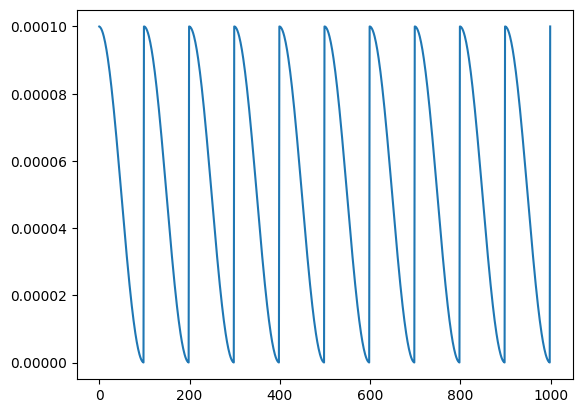

In [40]:
optimizer = optim.Adam(co_attn.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=1)

lrs = []
for epoch in range(1000):
    scheduler.step()
    print(optimizer.param_groups[0]['lr'])
    lrs.append(optimizer.param_groups[0]['lr'])

plt.plot(lrs)

# co-attn

In [23]:
co_attn = CoAttention(embed_size=dim_hidden, output_size=dim_hidden, return_attn=True)

In [24]:
a, b, attn_lista, attn_listb = co_attn(x, x)

In [29]:
attn_lista[0][0].item()

-1.4604681730270386

In [30]:
attn_listb[0][0].item()

-1.4604679346084595

In [27]:
attn_lista[0][0].eq(attn_listb[0][0])

tensor(False)

In [28]:
torch.all(torch.eq(a, b))

tensor(False)

# PMA SAB ISAB

In [54]:
dim_input = len(vocab)
hidden = 32
dim_hidden = hidden
num_heads = 4
num_outputs = 7
ln = True
num_inds = 6

pma = PMA(hidden, num_heads, num_outputs, ln=ln)
sab = SAB(hidden, hidden, num_heads, ln=ln)
isab = ISAB(hidden, hidden, num_heads, num_inds, ln=ln)

x = torch.ones((16, 72, 32))
x1 = torch.ones((16, 100, 32))

In [17]:
pma(x).shape

torch.Size([16, 7, 32])

In [18]:
sab(pma(x)).shape

torch.Size([16, 7, 32])

In [21]:
pma(x1).shape

torch.Size([16, 7, 32])

In [27]:
isab(x).shape

torch.Size([16, 72, 32])

In [28]:
isab(x1).shape

torch.Size([16, 100, 32])

In [55]:
x0 = torch.ones((16, 72, len(vocab)))

enc = nn.Sequential(
    ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
    ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))

enc((x0, None, None)).shape

AttributeError: 'tuple' object has no attribute 'size'

In [38]:
len(vocab)

27

# oas_dataset

In [41]:
oas_data = pickle.load(open("./OAS/oas_data.pkl", "rb"))
len(oas_data)

1572406

In [42]:
oas_data[0]

'GGSISSTSHY/CYFTGTT/ARSAEYVWSRGYFDY/SSNIGAGYG/GDT/QSYDSSLSGSRV'

In [43]:
train_set = OASDataset(corpus_path="./OAS/oas_data.pkl", vocab=vocab, train_test='train')

In [44]:
len(train_set)

1415165

In [45]:
len(train_set[0])

2

In [46]:
train_set[0][0]

[24,
 5,
 4,
 17,
 22,
 22,
 16,
 21,
 5,
 26,
 7,
 16,
 21,
 2,
 5,
 16,
 11,
 8,
 26,
 0,
 17,
 21,
 21,
 2,
 7,
 9,
 17,
 5,
 9,
 2,
 21,
 26,
 17,
 5,
 0,
 19,
 17,
 16,
 5,
 6,
 21,
 26,
 2,
 17,
 16,
 26,
 9,
 9,
 16,
 21,
 16,
 5,
 0,
 15,
 9,
 20,
 19,
 25]

In [47]:
train_set[0][1]

[23,
 5,
 4,
 0,
 0,
 16,
 0,
 0,
 0,
 26,
 0,
 16,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 17,
 21,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 16,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 23]

In [9]:
test_set = OASDataset(corpus_path="./OAS/oas_data.pkl", vocab=vocab, train_test='test')

In [10]:
len(test_set)

157241

In [11]:
test_set[0][0]

[24,
 5,
 4,
 17,
 22,
 16,
 16,
 21,
 0,
 26,
 7,
 22,
 5,
 16,
 5,
 5,
 16,
 17,
 26,
 0,
 8,
 11,
 21,
 21,
 2,
 16,
 16,
 5,
 21,
 21,
 4,
 16,
 22,
 4,
 2,
 21,
 26,
 16,
 16,
 22,
 7,
 22,
 16,
 11,
 21,
 22,
 15,
 11,
 11,
 26,
 0,
 0,
 20,
 2,
 2,
 22,
 9,
 16,
 5,
 20,
 22,
 25]

In [12]:
test_set[0][1]

[23,
 5,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 16,
 0,
 0,
 0,
 23]

# mask

In [102]:
c_mask = pickle.load(open("./c_mask.pkl", "rb"))
mask = pickle.load(open("./mask.pkl", "rb"))
x = pickle.load(open("./x.pkl", "rb"))

In [103]:
mask.shape, c_mask.shape

(torch.Size([64, 100, 100]), torch.Size([64, 100]))

In [104]:
x = x.detach().cpu()
x.shape

torch.Size([64, 100, 32])

In [105]:
isab = ISAB(dim_in=32, dim_out=64, num_heads=4, num_inds=100, ln=True)
isab(x).shape

torch.Size([64, 100, 64])

In [106]:
isab(x, mask, c_mask)

RuntimeError: The size of tensor a (64) must match the size of tensor b (256) at non-singleton dimension 0

In [124]:
attn = pickle.load(open("./attn.pkl", "rb"))
attn.shape

torch.Size([256, 100, 100])

In [125]:
mask.shape

torch.Size([64, 100, 100])

In [126]:
query_mask = pickle.load(open("./query_mask.pkl", "rb"))
mask = pickle.load(open("./mask.pkl", "rb"))
Q = pickle.load(open("./Q.pkl", "rb"))
A = pickle.load(open("./A.pkl", "rb"))

In [129]:
Q.shape

torch.Size([64, 100, 64])

In [127]:
query_mask.shape

torch.Size([256, 100, 4])

In [128]:
A.shape

torch.Size([256, 100, 100])

In [117]:
Q_ = torch.cat(Q.split(64//4, 2), 0)
Q_.shape

torch.Size([256, 100, 16])

# model

In [2]:
model = SetTransformer(dim_input=32, 
                     num_outputs=32, 
                     dim_output=32, 
                     dim_hidden=64, 
                     num_inds=6, 
                     num_heads=4, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True, 
                     share=False, 
                     use_BSS=False, 
                     use_CLIP=False, 
                     use_CosCLF=True)
model

SetTransformer(
  (embedding): Embedding(27, 32)
  (para_enc): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=32, out_features=64, bias=True)
        (fc_v): Linear(in_features=32, out_features=64, bias=True)
        (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=32, out_features=64, bias=True)
        (fc_k): Linear(in_features=64, out_features=64, bias=True)
        (fc_v): Linear(in_features=64, out_features=64, bias=True)
        (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=64, out_features=64, bias=True)
      )
    )
    (1): ISAB(
      (mab0): MAB(
        

# config file check

In [20]:
config = pickle.load(open("./results/CoV-AbDab/pesi_05-29-00-56-03/config_file", "rb"))
config

{'data_type': 'seq1_neg0',
 'data_path': '../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv',
 'use_fine_tune': 'CosCLF',
 'fix_FE': False,
 'use_pair': False,
 'use_reg': False,
 'use_BSS': False,
 'use_aug': True,
 'ntimes': 3,
 'kfold': 10,
 'batch_size': 16,
 'model_name': 'pesi_CosCLF',
 'clip_norm': 0.5,
 'diff_lr': False,
 'use_part': True}

# baseline++

In [10]:
cls = distLinear(indim=32, outdim=2)
cls.L.weight.shape, cls.L.weight

(torch.Size([2, 32]),
 tensor([[ 0.0401, -0.1232, -0.0484,  0.0843,  0.0607,  0.1285,  0.1248,  0.0693,
           0.0961, -0.0792,  0.0382,  0.0602, -0.1740, -0.1204,  0.0562,  0.0359,
          -0.1482, -0.0603, -0.0491,  0.0592, -0.1110,  0.1502,  0.1565, -0.1695,
          -0.1526,  0.0240, -0.0506, -0.1251, -0.0197, -0.0916,  0.0080, -0.1507],
         [-0.0040,  0.1407,  0.0548, -0.0698,  0.1091,  0.1348,  0.1262, -0.1553,
           0.1696,  0.1180, -0.0121,  0.1376, -0.0835, -0.1104,  0.1198, -0.0259,
          -0.0506, -0.1263, -0.0751, -0.0654, -0.0889, -0.0788,  0.0169,  0.1579,
           0.1150,  0.0804,  0.1103,  0.0678,  0.1690, -0.0795,  0.1380,  0.1611]],
        grad_fn=<WeightNormInterfaceBackward0>))

In [73]:
Wb = cls.L.weight.T
Wb.shape, Wb

(torch.Size([32, 2]),
 tensor([[ 0.0401, -0.0040],
         [-0.1232,  0.1407],
         [-0.0484,  0.0548],
         [ 0.0843, -0.0698],
         [ 0.0607,  0.1091],
         [ 0.1285,  0.1348],
         [ 0.1248,  0.1262],
         [ 0.0693, -0.1553],
         [ 0.0961,  0.1696],
         [-0.0792,  0.1180],
         [ 0.0382, -0.0121],
         [ 0.0602,  0.1376],
         [-0.1740, -0.0835],
         [-0.1204, -0.1104],
         [ 0.0562,  0.1198],
         [ 0.0359, -0.0259],
         [-0.1482, -0.0506],
         [-0.0603, -0.1263],
         [-0.0491, -0.0751],
         [ 0.0592, -0.0654],
         [-0.1110, -0.0889],
         [ 0.1502, -0.0788],
         [ 0.1565,  0.0169],
         [-0.1695,  0.1579],
         [-0.1526,  0.1150],
         [ 0.0240,  0.0804],
         [-0.0506,  0.1103],
         [-0.1251,  0.0678],
         [-0.0197,  0.1690],
         [-0.0916, -0.0795],
         [ 0.0080,  0.1380],
         [-0.1507,  0.1611]], grad_fn=<PermuteBackward0>))

In [92]:
x1 = torch.ones((2, 32))
x2 = torch.zeros((1,32))
x2 -= 0.2
x = torch.vstack([x1, x2])
x.shape, x

(torch.Size([3, 32]),
 tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
         [-0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
          -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
          -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
          -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -

In [77]:
# my own implementation
x@Wb, torch.norm(x, p=2, dim=1), torch.norm(Wb, p=2, dim=1)

(tensor([[-0.4815,  1.1016],
         [-0.4815,  1.1016],
         [-0.0963,  0.2203]], grad_fn=<MmBackward0>),
 tensor([5.6569, 5.6569, 1.1314]),
 tensor([0.0403, 0.1870, 0.0731, 0.1094, 0.1248, 0.1862, 0.1775, 0.1700, 0.1950,
         0.1421, 0.0401, 0.1502, 0.1930, 0.1633, 0.1323, 0.0443, 0.1566, 0.1399,
         0.0897, 0.0882, 0.1422, 0.1696, 0.1574, 0.2317, 0.1911, 0.0840, 0.1213,
         0.1423, 0.1701, 0.1213, 0.1382, 0.2206], grad_fn=<NormBackward1>))

In [78]:
(torch.norm(x, p=2, dim =1).unsqueeze(1).expand_as(x)).shape, torch.norm(x, p=2, dim =1).unsqueeze(1).expand_as(x)

(torch.Size([3, 32]),
 tensor([[5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
          5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
          5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
          5.6569, 5.6569, 5.6569, 5.6569, 5.6569],
         [5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
          5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
          5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
          5.6569, 5.6569, 5.6569, 5.6569, 5.6569],
         [1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314,
          1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314,
          1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314,
          1.1314, 1.1314, 1.1314, 1.1314, 1.1314]]))

In [79]:
(x/torch.norm(x, p=2, dim=0)).shape, x/torch.norm(x, p=2, dim=0)

(torch.Size([3, 32]),
 tensor([[0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001,
          0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001,
          0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001,
          0.7001, 0.7001, 0.7001, 0.7001, 0.7001],
         [0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001,
          0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001,
          0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001, 0.7001,
          0.7001, 0.7001, 0.7001, 0.7001, 0.7001],
         [0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400,
          0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400,
          0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400, 0.1400,
          0.1400, 0.1400, 0.1400, 0.1400, 0.1400]]))

In [80]:
(Wb/torch.norm(Wb, p=2, dim=0)).shape, Wb/torch.norm(Wb, p=2, dim=0)

(torch.Size([32, 2]),
 tensor([[ 0.0699, -0.0065],
         [-0.2145,  0.2289],
         [-0.0842,  0.0891],
         [ 0.1467, -0.1136],
         [ 0.1057,  0.1774],
         [ 0.2237,  0.2193],
         [ 0.2173,  0.2053],
         [ 0.1206, -0.2526],
         [ 0.1673,  0.2760],
         [-0.1378,  0.1920],
         [ 0.0666, -0.0197],
         [ 0.1047,  0.2239],
         [-0.3029, -0.1358],
         [-0.2096, -0.1795],
         [ 0.0978,  0.1948],
         [ 0.0625, -0.0421],
         [-0.2581, -0.0823],
         [-0.1050, -0.2054],
         [-0.0854, -0.1222],
         [ 0.1031, -0.1064],
         [-0.1933, -0.1446],
         [ 0.2615, -0.1282],
         [ 0.2724,  0.0276],
         [-0.2952,  0.2569],
         [-0.2657,  0.1871],
         [ 0.0418,  0.1309],
         [-0.0881,  0.1794],
         [-0.2178,  0.1102],
         [-0.0343,  0.2749],
         [-0.1596, -0.1294],
         [ 0.0139,  0.2245],
         [-0.2624,  0.2621]], grad_fn=<DivBackward0>))

In [81]:
(x/torch.norm(x, p=2, dim=0)) @ (Wb/torch.norm(Wb, p=2, dim=0))

tensor([[-0.5869,  1.2548],
        [-0.5869,  1.2548],
        [-0.1174,  0.2510]], grad_fn=<MmBackward0>)

In [93]:
# author's implementation

scores = cls.forward(x)
scores

tensor([[-0.1702,  0.3895],
        [-0.1702,  0.3895],
        [ 0.1702, -0.3895]], grad_fn=<MulBackward0>)

In [94]:
scores, labels = scores.data.topk(1,1,True,True)
scores, labels

(tensor([[0.3895],
         [0.3895],
         [0.1702]]),
 tensor([[1],
         [1],
         [0]]))

In [96]:
x_norm = torch.norm(x, p=2, dim =1).unsqueeze(1).expand_as(x)
x_norm

tensor([[5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
         5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
         5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
         5.6569, 5.6569, 5.6569, 5.6569, 5.6569],
        [5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
         5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
         5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569, 5.6569,
         5.6569, 5.6569, 5.6569, 5.6569, 5.6569],
        [1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314,
         1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314,
         1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314, 1.1314,
         1.1314, 1.1314, 1.1314, 1.1314, 1.1314]])

In [97]:
x_normalized = x.div(x_norm+ 0.00001)
x_normalized

tensor([[ 0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,
          0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,
          0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,
          0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768],
        [ 0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,
          0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,
          0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,
          0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768,  0.1768],
        [-0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768,
         -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768,
         -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768,
         -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768, -0.1768]])

In [6]:
cls = distLinear(indim=32, outdim=2)
para = torch.ones((16,32))
epi = torch.ones((16,32))

In [10]:
pred = cls.forward(para*epi)
pred.shape, pred

(torch.Size([16, 2]),
 tensor([[ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939],
         [ 0.0203, -0.1939]], grad_fn=<MulBackward0>))

In [19]:
F.softmax(pred).max(dim=1).values

tensor([0.5533, 0.5533, 0.5533, 0.5533, 0.5533, 0.5533, 0.5533, 0.5533, 0.5533,
        0.5533, 0.5533, 0.5533, 0.5533, 0.5533, 0.5533, 0.5533],
       grad_fn=<MaxBackward0>)

In [15]:
pred1 = torch.tensor([[0.2,0.8], [0.4, 0.6], [0.7, 0.3]])
pred1.shape, pred1

(torch.Size([3, 2]),
 tensor([[0.2000, 0.8000],
         [0.4000, 0.6000],
         [0.7000, 0.3000]]))

In [17]:
pred1.max(dim=1).values

tensor([0.8000, 0.6000, 0.7000])

# transfer weights

In [38]:
model = torch.load("./results/SAbDab/full/seq1_neg0/pesi_CLIP/model_best.pth")
model.embedding.weight[1,:]

tensor([ 1.7428,  0.6113,  1.1294, -0.6985,  0.0217,  0.5714, -0.0743,  0.1057,
         0.2319,  0.2670, -0.9700,  0.0763,  0.4603, -3.8959, -0.6182,  0.8623,
        -1.0760, -0.9592,  0.9274, -0.5777,  0.1985, -1.5596,  1.0333, -0.2352,
        -0.3648, -1.0239, -0.9126, -1.9418, -0.8806,  0.2797, -1.3338, -0.3396],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [10]:
for name, param in model.state_dict().items():
    print(name)

logit_scale
embedding.weight
para_enc.0.I
para_enc.0.mab0.fc_q.weight
para_enc.0.mab0.fc_q.bias
para_enc.0.mab0.fc_k.weight
para_enc.0.mab0.fc_k.bias
para_enc.0.mab0.fc_v.weight
para_enc.0.mab0.fc_v.bias
para_enc.0.mab0.ln0.weight
para_enc.0.mab0.ln0.bias
para_enc.0.mab0.ln1.weight
para_enc.0.mab0.ln1.bias
para_enc.0.mab0.fc_o.weight
para_enc.0.mab0.fc_o.bias
para_enc.0.mab1.fc_q.weight
para_enc.0.mab1.fc_q.bias
para_enc.0.mab1.fc_k.weight
para_enc.0.mab1.fc_k.bias
para_enc.0.mab1.fc_v.weight
para_enc.0.mab1.fc_v.bias
para_enc.0.mab1.ln0.weight
para_enc.0.mab1.ln0.bias
para_enc.0.mab1.ln1.weight
para_enc.0.mab1.ln1.bias
para_enc.0.mab1.fc_o.weight
para_enc.0.mab1.fc_o.bias
para_enc.1.I
para_enc.1.mab0.fc_q.weight
para_enc.1.mab0.fc_q.bias
para_enc.1.mab0.fc_k.weight
para_enc.1.mab0.fc_k.bias
para_enc.1.mab0.fc_v.weight
para_enc.1.mab0.fc_v.bias
para_enc.1.mab0.ln0.weight
para_enc.1.mab0.ln0.bias
para_enc.1.mab0.ln1.weight
para_enc.1.mab0.ln1.bias
para_enc.1.mab0.fc_o.weight
para_enc.1.

In [43]:
for k,v in model.named_parameters():
    print(k)

logit_scale
embedding.weight
para_enc.0.I
para_enc.0.mab0.fc_q.weight
para_enc.0.mab0.fc_q.bias
para_enc.0.mab0.fc_k.weight
para_enc.0.mab0.fc_k.bias
para_enc.0.mab0.fc_v.weight
para_enc.0.mab0.fc_v.bias
para_enc.0.mab0.ln0.weight
para_enc.0.mab0.ln0.bias
para_enc.0.mab0.ln1.weight
para_enc.0.mab0.ln1.bias
para_enc.0.mab0.fc_o.weight
para_enc.0.mab0.fc_o.bias
para_enc.0.mab1.fc_q.weight
para_enc.0.mab1.fc_q.bias
para_enc.0.mab1.fc_k.weight
para_enc.0.mab1.fc_k.bias
para_enc.0.mab1.fc_v.weight
para_enc.0.mab1.fc_v.bias
para_enc.0.mab1.ln0.weight
para_enc.0.mab1.ln0.bias
para_enc.0.mab1.ln1.weight
para_enc.0.mab1.ln1.bias
para_enc.0.mab1.fc_o.weight
para_enc.0.mab1.fc_o.bias
para_enc.1.I
para_enc.1.mab0.fc_q.weight
para_enc.1.mab0.fc_q.bias
para_enc.1.mab0.fc_k.weight
para_enc.1.mab0.fc_k.bias
para_enc.1.mab0.fc_v.weight
para_enc.1.mab0.fc_v.bias
para_enc.1.mab0.ln0.weight
para_enc.1.mab0.ln0.bias
para_enc.1.mab0.ln1.weight
para_enc.1.mab0.ln1.bias
para_enc.1.mab0.fc_o.weight
para_enc.1.

In [50]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor(3.0860, device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 1.6886e-01, -8.5702e-01, -6.1770e-01,  1.0212e+00,  3.3773e-01,
          7.9692e-01,  9.5265e-02, -9.6743e-01, -1.6787e+00,  1.3724e+00,
         -1.9836e-01,  1.7408e+00,  5.7442e-01, -3.9866e-01,  1.4253e+00,
         -6.2083e-01, -1.7735e+00, -2.9812e-02, -1.1419e+00, -8.4446e-02,
         -1.5557e-01, -9.6006e-03,  7.9007e-01, -1.4172e+00,  6.4402e-01,
         -1.1098e+00,  7.0703e-01,  7.4363e-01,  1.4899e+00,  1.0250e+00,
          4.8590e-01,  1.1064e+00],
        [ 1.7428e+00,  6.1131e-01,  1.1294e+00, -6.9851e-01,  2.1715e-02,
          5.7139e-01, -7.4295e-02,  1.0572e-01,  2.3195e-01,  2.6697e-01,
         -9.7001e-01,  7.6251e-02,  4.6034e-01, -3.8959e+00, -6.1823e-01,
          8.6226e-01, -1.0760e+00, -9.5920e-01,  9.2740e-01, -5.7772e-01,
          1.9847e-01, -1.5596e+00,  1.0333e+00, -2.3523e-01, -3.6476e-01,
         -1.0239e+00, -9.1257e-01, -1.9418e+00, -8.806

In [39]:
model1 = SetTransformer(dim_input=32, 
                         num_outputs=32, 
                         dim_output=32, 
                         dim_hidden=64, 
                         num_inds=6, 
                         num_heads=4, 
                         ln=True, 
                         dropout=0.5, 
                         use_coattn=True, 
                         share=False, 
                         use_BSS=False, 
                         use_CLIP=False)
model1.embedding.state_dict()["weight"][1,:]

tensor([-1.2692,  0.4436, -0.1367,  1.5390,  0.5267, -0.1158,  0.6800, -0.5296,
         0.4166,  0.9507,  0.3054, -0.4750, -1.5038, -0.3903,  0.4481, -0.7822,
        -0.2305,  1.8570, -2.2536, -0.3374, -1.0979,  1.5404,  0.6799,  0.7584,
        -1.6996, -0.5421, -0.4127, -0.0690,  0.5773,  1.1173, -1.1544, -1.0703])

In [41]:
model1.embedding.load_state_dict(model.embedding.state_dict())
model1.embedding.state_dict()["weight"][1,:]

tensor([ 1.7428,  0.6113,  1.1294, -0.6985,  0.0217,  0.5714, -0.0743,  0.1057,
         0.2319,  0.2670, -0.9700,  0.0763,  0.4603, -3.8959, -0.6182,  0.8623,
        -1.0760, -0.9592,  0.9274, -0.5777,  0.1985, -1.5596,  1.0333, -0.2352,
        -0.3648, -1.0239, -0.9126, -1.9418, -0.8806,  0.2797, -1.3338, -0.3396])

# FrameSlidingTransformer

In [12]:
def frame_slice(x, frame_size=6):
    """
    Args:
        x: (B, L, E)
        frame_size: size of frames
    Returns:
        frames: (num_frames*B, frame_size, C)
    """
    B, L, E = x.shape
    x = x.view(B, L // frame_size, frame_size, E)
    frames = x.contiguous().view(-1, frame_size, E)

    return frames

x = torch.ones(16, 72, 32)

x1 = frame_slice(x, frame_size=3)
x1.shape

torch.Size([384, 3, 32])

In [8]:
B, L, E

(16, 71, 32)

In [9]:
L // frame_size

23

In [10]:
16*23*3*32, 16*71*32

(35328, 36352)

In [7]:
frame_size = 3

B, L, E = x.shape
x1 = x.view(B, L // frame_size, frame_size, E)
x1.shape

RuntimeError: shape '[16, 23, 3, 32]' is invalid for input of size 36352

# SequenceEncoder

In [2]:
model = SequenceEncoder(seq_encoder_type="transformer", num_layers=2, embed_size=64, hidden=512, dropout=0, nhead=4)
model

SequenceEncoder(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (seq_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear

In [4]:
# transformer
x = torch.ones(16, 48, 64)
model(x).shape

torch.Size([16, 48, 64])

In [5]:
# lstm
x = torch.ones(16, 48, 64)
model(x)[0].shape

torch.Size([16, 48, 64])

# SetModel

In [2]:
embed_size = 32
hidden = 64

model = SetModel(embed_size=embed_size, 
                 hidden=hidden, 
                 num_layers=2, 
                 dropout=0.1, 
                 k4kmer=5, 
                 use_pretrain=False, 
                 use_coattn=True, 
                 seq_encoder_type="transformer", 
                 num_heads=4, 
                 num_inds=6, 
                 num_outputs=6, 
                 ln=False).cuda()

print("total params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

model

total params:  506721


SetModel(
  (embedding): Embedding(27, 32)
  (seq_encoder): SequenceEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (seq_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynami

In [4]:
x = torch.ones(12, 5, 32)
y = torch.mean(x, dim=1)
y.shape

torch.Size([12, 32])

In [3]:
para = ["+ABCD-##", "+ABCD-##", "+ABCD-##"]
epi = ["+AD-##", "+AD-##", "+AD-##"]

out = model(para, epi)
out, out.shape

torch.Size([3, 8, 32])
torch.Size([12, 5, 32])
torch.Size([12, 5, 32])
after mean  torch.Size([12, 32])
torch.Size([3, 4, 32])
torch.Size([3, 6, 32])
torch.Size([3, 6, 32]) torch.Size([3, 6, 32])


(tensor([[0.4661],
         [0.4661],
         [0.4671]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 torch.Size([3, 1]))

# transformerencoder(layer)

In [7]:
encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4, batch_first=True)
seq_encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=2)
seq_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_featu

# kmer

In [23]:
def kmer_embed(seqs, k=3):
    ngram_li = []
    for seq in seqs:
        ngram = [seq[i:i+k, :] for i in range(len(seq)-k+1)]
        ngram_li.append(torch.stack(ngram, dim=0))
    
    return torch.vstack(ngram_li)

In [24]:
x = torch.ones(16, 48, 32)

y = kmer_embed(x, k=3)
y.shape

torch.Size([736, 3, 32])

In [21]:
def kmer(seq, k=3):
    ngram = [seq[i:i+k] for i in range(len(seq)-k+1)]
    return ngram

s = "+ABCDEFG-##"
kmer(s, k=3)

['+AB', 'ABC', 'BCD', 'CDE', 'DEF', 'EFG', 'FG-', 'G-#', '-##']

In [24]:
s = torch.ones(2,3,4)
kmer(s, k=3)

[]

In [ ]:
batch, seq, hidden

In [74]:
def kmer_embed(seqs, k=3):
    ngram_li = []
    for seq in seqs:
        ngram = [torch.mean(seq[i:i+k, :], dim=0) for i in range(len(seq)-k+1)]
        ngram_li.append(torch.vstack(ngram))

    return torch.stack(ngram_li)

seqs = torch.tensor(
        [[[1., 1., 1.],
         [2., 2., 2.],
         [3., 3., 3.],
         [4., 4., 4.],
         [5., 5., 5.]],

        [[5., 5., 5.],
         [1., 1., 1.],
         [2., 2., 2.],
         [3., 3., 3.],
         [4., 4., 4.]]])

ngram_li = []
for seq in seqs:
    ngram = [torch.mean(seq[i:i+k, :], dim=0) for i in range(len(seq)-k+1)]
    ngram_li.append(torch.vstack(ngram))

final = torch.stack(ngram_li)
final, final.shape

(tensor([[[2.0000, 2.0000, 2.0000],
          [3.0000, 3.0000, 3.0000],
          [4.0000, 4.0000, 4.0000]],
 
         [[2.6667, 2.6667, 2.6667],
          [2.0000, 2.0000, 2.0000],
          [3.0000, 3.0000, 3.0000]]]),
 torch.Size([2, 3, 3]))

In [77]:
res = kmer_embed(seqs, k=3)
res, res.shape

(tensor([[[2.0000, 2.0000, 2.0000],
          [3.0000, 3.0000, 3.0000],
          [4.0000, 4.0000, 4.0000]],
 
         [[2.6667, 2.6667, 2.6667],
          [2.0000, 2.0000, 2.0000],
          [3.0000, 3.0000, 3.0000]]]),
 torch.Size([2, 3, 3]))

# align

In [2]:
target = "GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV"
query = "GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV"

aligner = Align.PairwiseAligner()
aligner = Align.PairwiseAligner(match_score=1.0)

score = aligner.score(target, query)
score = score / max(len(target), len(query))
score

1.0

# how to get attn weights

In [2]:
model = nn.Transformer()

model

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, in

In [67]:
model.encoder.layers[-1].state_dict()['self_attn.in_proj_weight'].shape, model.encoder.layers[-1].state_dict()['self_attn.in_proj_weight']

(torch.Size([1536, 512]),
 tensor([[ 0.0470, -0.0028,  0.0163,  ..., -0.0414,  0.0355, -0.0227],
         [ 0.0279,  0.0492,  0.0412,  ...,  0.0506, -0.0014, -0.0139],
         [ 0.0475,  0.0345,  0.0353,  ...,  0.0470, -0.0176, -0.0121],
         ...,
         [-0.0519, -0.0491,  0.0292,  ...,  0.0364, -0.0531, -0.0331],
         [-0.0325,  0.0164,  0.0195,  ..., -0.0243, -0.0272, -0.0313],
         [-0.0150,  0.0301, -0.0027,  ...,  0.0330, -0.0533, -0.0485]]))

In [76]:
model.decoder.layers[-1].state_dict()['self_attn.out_proj.weight'].shape, model.decoder.layers[-1].state_dict()['self_attn.out_proj.weight']

(torch.Size([512, 512]),
 tensor([[ 0.0727,  0.0576,  0.0258,  ...,  0.0696,  0.0730, -0.0514],
         [-0.0191, -0.0108, -0.0535,  ...,  0.0299, -0.0091,  0.0592],
         [ 0.0610, -0.0025, -0.0308,  ..., -0.0552, -0.0339, -0.0194],
         ...,
         [ 0.0689, -0.0239, -0.0136,  ..., -0.0097, -0.0262, -0.0103],
         [ 0.0089, -0.0052, -0.0376,  ...,  0.0385, -0.0002, -0.0738],
         [-0.0671, -0.0263, -0.0067,  ...,  0.0348, -0.0179,  0.0467]]))

In [58]:
model.decoder.layers[-1].state_dict()['self_attn.in_proj_weight'].shape, model.decoder.layers[-1].state_dict()['self_attn.in_proj_weight']

(torch.Size([1536, 512]),
 tensor([[ 0.0138,  0.0402,  0.0142,  ...,  0.0350, -0.0382,  0.0134],
         [ 0.0315, -0.0208, -0.0037,  ...,  0.0329,  0.0324,  0.0524],
         [ 0.0132, -0.0481, -0.0317,  ..., -0.0450, -0.0170, -0.0525],
         ...,
         [ 0.0151,  0.0279,  0.0342,  ...,  0.0286, -0.0049, -0.0132],
         [ 0.0532, -0.0446, -0.0320,  ..., -0.0411,  0.0289, -0.0172],
         [ 0.0206,  0.0100,  0.0536,  ..., -0.0281, -0.0387,  0.0047]]))

In [42]:
model.decoder.layers[-1].self_attn.in_proj_weight.shape, model.decoder.layers[-1].self_attn.in_proj_weight

(torch.Size([1536, 512]),
 Parameter containing:
 tensor([[ 0.0138,  0.0402,  0.0142,  ...,  0.0350, -0.0382,  0.0134],
         [ 0.0315, -0.0208, -0.0037,  ...,  0.0329,  0.0324,  0.0524],
         [ 0.0132, -0.0481, -0.0317,  ..., -0.0450, -0.0170, -0.0525],
         ...,
         [ 0.0151,  0.0279,  0.0342,  ...,  0.0286, -0.0049, -0.0132],
         [ 0.0532, -0.0446, -0.0320,  ..., -0.0411,  0.0289, -0.0172],
         [ 0.0206,  0.0100,  0.0536,  ..., -0.0281, -0.0387,  0.0047]],
        requires_grad=True))

In [39]:
dir(model.decoder.layers[-1].self_attn)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_qkv_same_embed_dim',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_reset_p

In [36]:
model.decoder._modules["layers"][-1].multihead_attn._parameters["in_proj_weight"].shape

torch.Size([1536, 512])

In [31]:
model.decoder._modules["layers"][-1].multihead_attn._parameters

OrderedDict([('in_proj_weight',
              Parameter containing:
              tensor([[-0.0294, -0.0511,  0.0045,  ...,  0.0381,  0.0291,  0.0405],
                      [-0.0378, -0.0161,  0.0465,  ..., -0.0185, -0.0045,  0.0329],
                      [-0.0140,  0.0475, -0.0318,  ...,  0.0461,  0.0257,  0.0066],
                      ...,
                      [-0.0535,  0.0461, -0.0355,  ..., -0.0245,  0.0480, -0.0154],
                      [-0.0343, -0.0304,  0.0292,  ..., -0.0300,  0.0525,  0.0037],
                      [ 0.0369, -0.0137, -0.0355,  ...,  0.0328,  0.0130, -0.0061]],
                     requires_grad=True)),
             ('q_proj_weight', None),
             ('k_proj_weight', None),
             ('v_proj_weight', None),
             ('in_proj_bias',
              Parameter containing:
              tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True))])

In [30]:
dir(model.decoder._modules["layers"][-1].multihead_attn)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_qkv_same_embed_dim',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_reset_p

In [22]:
dir(model.decoder._modules["layers"][-1])

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_ff_block',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_mha_block',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_sa

In [3]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_reset_parameters',
 '_save_to_state_dict',
 '_slow_forward',
 '_sta

# data EDA

In [2]:
data = pickle.load(open("../../MSAI_Project/codes/data_files/data.json", "rb"))
type(data), len(data)

(list, 5359)

In [3]:
data[0].keys()

dict_keys(['pdb', 'Hchain', 'Lchain', 'Achain', 'Hseq', 'Lseq', 'Aseq', 'L1', 'L2', 'L3', 'H1', 'H2', 'H3', 'Hpos', 'Lpos', 'Apos'])

In [4]:
len(data[0]["Hpos"])

123

In [5]:
len(data[0]["Lpos"])

110

In [6]:
len(data[0]["Apos"][0])

392

In [7]:
data[0]["Apos"][0]

[array([[ 81.858,  -7.199, 197.021],
        [ 81.735,  -6.449, 198.265],
        [ 80.284,  -6.421, 198.728],
        [ 79.74 ,  -5.362, 199.036]], dtype=float32),
 array([[ 79.66 ,  -7.596, 198.767],
        [ 78.278,  -7.837, 199.157],
        [ 77.269,  -7.526, 198.055],
        [ 76.075,  -7.745, 198.261]], dtype=float32),
 array([[ 77.695,  -7.022, 196.897],
        [ 76.793,  -6.774, 195.785],
        [ 77.323,  -7.296, 194.458],
        [ 76.538,  -7.469, 193.52 ]], dtype=float32),
 array([[ 78.63 ,  -7.552, 194.352],
        [ 79.196,  -8.074, 193.112],
        [ 78.916,  -9.554, 192.915],
        [ 78.921, -10.028, 191.772]], dtype=float32),
 array([[ 78.667, -10.296, 193.99 ],
        [ 78.411, -11.718, 193.885],
        [ 76.953, -12.063, 193.664],
        [ 76.593, -13.242, 193.593]], dtype=float32),
 array([[ 76.106, -11.047, 193.552],
        [ 74.68 , -11.249, 193.323],
        [ 74.461, -11.614, 191.862],
        [ 75.008, -10.971, 190.958]], dtype=float32),
 array([[ 

# test utils.py/get_knearest_epi

In [22]:
import heapq

In [41]:
mode = 0
K = 48

# get k nearest (K = 48)
if mode==0:
    for i in range(len(data)):
        # maintain a heap with k amino acids
        epitope = []
        Apos = np.hstack(data[i]["Apos"])
        Aseq = "".join(data[i]["Aseq"])
        for Aidx in range(len(Aseq)):
            # traverse heavy/light chain to find nearest distance
            nearest_dist = np.inf
            for Hidx in range(len(data[i]["Hpos"])):
                cur_dist = np.sqrt(np.sum((Apos[Aidx][0] - data[i]["Hpos"][Hidx][0]) ** 2))
                nearest_dist = np.min([cur_dist, nearest_dist])
            for Lidx in range(len(data[i]["Lpos"])):
                cur_dist = np.sqrt(np.sum((Apos[Aidx][0] - data[i]["Lpos"][Lidx][0]) ** 2))
                nearest_dist = np.min([cur_dist, nearest_dist])

            epitope.append((nearest_dist, Aidx))

        epitope_heap = heapq.nsmallest(K, epitope, key=lambda x:x[0])
        epitope_index = sorted([i[1] for i in epitope_heap])

        data[i]["epitope"] = "".join([aseq[i] for i in epitope_index])
        break

In [42]:
data[0].keys()

dict_keys(['pdb', 'Hchain', 'Lchain', 'Achain', 'Hseq', 'Lseq', 'Aseq', 'L1', 'L2', 'L3', 'H1', 'H2', 'H3', 'Hpos', 'Lpos', 'Apos', 'epitope'])

In [47]:
data[0]["epitope"]

'NMEVSCYEASISDFACSKKMTGKLTMNNKHPWHAADTGTPHWMDGAKG'

In [49]:
pickle.dump(data, open("./demo_data.pkl", "wb"))

In [50]:
data1 = pickle.load(open("./demo_data.pkl", "rb"))
len(data1)

5359

In [52]:
data1[0].keys()

dict_keys(['pdb', 'Hchain', 'Lchain', 'Achain', 'Hseq', 'Lseq', 'Aseq', 'L1', 'L2', 'L3', 'H1', 'H2', 'H3', 'Hpos', 'Lpos', 'Apos', 'epitope'])

In [51]:
len(data)

5359

In [38]:
# aseq = "".join(data[i]["Aseq"])
# epi_index = data[0]["epitope"]

# "".join([aseq[i] for i in epi_index])

'NMEVSCYEASISDFACSKKMTGKLTMNNKHPWHAADTGTPHWMDGAKG'

In [45]:
epitope_heap

[(4.025998115539551, 120),
 (4.572774887084961, 122),
 (4.610614776611328, 279),
 (4.689812660217285, 123),
 (4.719902038574219, 125),
 (4.904451370239258, 121),
 (5.198207378387451, 233),
 (5.715717315673828, 232),
 (5.928899765014648, 204),
 (5.9649763107299805, 124),
 (6.015800476074219, 205),
 (6.222243785858154, 278),
 (6.478855133056641, 126),
 (6.5371809005737305, 207),
 (6.65501070022583, 280),
 (6.8116655349731445, 206),
 (6.899214744567871, 119),
 (7.3167405128479, 231),
 (7.490304946899414, 127),
 (7.526638507843018, 234),
 (7.834255218505859, 235),
 (7.8423590660095215, 208),
 (7.913382530212402, 60),
 (8.017367362976074, 277),
 (8.02734375, 230),
 (8.091531753540039, 225),
 (8.226497650146484, 66),
 (8.301057815551758, 59),
 (8.370485305786133, 228),
 (8.457207679748535, 61),
 (8.466352462768555, 276),
 (8.509766578674316, 62),
 (8.640408515930176, 63),
 (8.71596622467041, 229),
 (8.930583953857422, 203),
 (8.934435844421387, 54),
 (9.243196487426758, 55),
 (9.259186744689

In [46]:
epitope

[(32.8936653137207, 0),
 (30.107135772705078, 1),
 (30.423547744750977, 2),
 (32.810401916503906, 3),
 (31.96693992614746, 4),
 (30.500171661376953, 5),
 (30.18033218383789, 6),
 (30.703096389770508, 7),
 (32.23325729370117, 8),
 (34.15449905395508, 9),
 (37.3301887512207, 10),
 (38.003326416015625, 11),
 (40.524864196777344, 12),
 (42.45100784301758, 13),
 (42.081947326660156, 14),
 (41.65396499633789, 15),
 (43.87492370605469, 16),
 (42.427913665771484, 17),
 (40.55342102050781, 18),
 (38.62664031982422, 19),
 (36.73564529418945, 20),
 (36.21327590942383, 21),
 (33.63908386230469, 22),
 (32.01983642578125, 23),
 (28.799253463745117, 24),
 (27.46338653564453, 25),
 (24.877246856689453, 26),
 (24.013507843017578, 27),
 (26.24178695678711, 28),
 (28.833772659301758, 29),
 (30.73711585998535, 30),
 (33.57426071166992, 31),
 (35.20677947998047, 32),
 (38.42568588256836, 33),
 (40.62495040893555, 34),
 (43.51736831665039, 35),
 (43.81686782836914, 36),
 (41.41398239135742, 37),
 (38.782077